# Convolutional Neural Network

Implement a simple convolutional neural network that can recognize digits using PyTorch.

<h3>Python Initialization</h3>

In [1]:
# import packages
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Seed the random number generator
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
# Check whether you have a gpu
# If you have a gpu, model training will be done on gpu
# which is significantly faster than training on cpu
gpu_available = torch.cuda.is_available()
print("GPU is available:", gpu_available)

GPU is available: False


## Convolutional Neural Network

### Part One:  Loading the Dataset and Setting up Dataloader

In [4]:
# Setup the training set and test set
trainset = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

# Setting up dataloader
# A dataloader stacks small batches (128 in our case) of dataset into Tensors for ease of training
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, drop_last=True, batch_size=512, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, drop_last=False, batch_size=512, num_workers=2)

c:\users\joshu\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


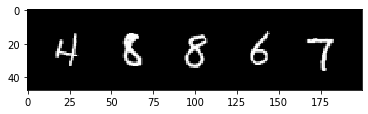

In [5]:
# Visualize the data
# The following line gets us a small batch of data
# X is a tensor of size (128, 1, 28, 28) that contains a batch of images
# y is a tensor of size (128) that contains the labels in X
X, y = iter(trainloader).next()

def visualize_data(X):
    img_grid = torchvision.utils.make_grid(X[:5], padding=10)
    img_grid = img_grid.numpy()
    plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation='nearest')
    plt.show()

visualize_data(X)

### Part Two: Define a convolutional neural network

#### Define a building block of a convolutional neural network

In [6]:
class Block(nn.Module):
    
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1):
        super(Block, self).__init__()
        
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.stride = stride
        
        # This block contains a convolutional layer then a batch normalization layer
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channel)
    
    def forward(self, x):
        # this passes the input image through a convolutional layer
        # followed by a batch normalization layer and relu transition
        out = F.relu(self.bn(self.conv(x)))
        
        return out

In [7]:
# Create a block that is made up of 10 filters size 3x3 and stride 1
# The block takes in a image of 1 channel
Block1 = Block(1, 10, 3, 1)
out = Block1(X)

# After passing our image through block 1 we get the following tensor
print(out.shape)

torch.Size([512, 10, 26, 26])


### Build a convolutional neural network using the block class

In this section, build a convolutional network that consists of 4 blocks, an average pooling layer and a fully connected layer.

In [8]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        # First block takes in the image
        # Filter specification:
        # Num filters=16, kernel size=3, stride=1
        self.block1 = Block(1, 16, 3, 1)
        
        # Second block takes in the output of the first block
        # Filter specification:
        # Num filters=32, kernel size=3, stride=1
        self.block2 = Block(16, 32, 3, 1)
        
        # Third block takes in the output of the 2nd block
        # Filter specification:
        # Num filters=64, kernel size=3, stride=1
        self.block3 = Block(32, 64, 3, 1)
        
        # Fourth block takes in the output of the 3rd block
        # Filter specification:
        # Num filters=128, kernel size 3, stride 1
        self.block4 = Block(64, 128, 3, 1)
        
        # This is the average pooling layer
        # This is applied to the output of the last convolutional layer
        # Essentially, it averages feature maps spatially to a single number
        # For instance, if the output of the last conv layer is of size (128, 15, 4, 4)
        # the following layer will average the 4x4 array into a single number
        # so the output of applying this layer would have size (128, 15, 1, 1)
        # This operation vectorizes the feature maps so that we can have a vector
        # that can be passed into a simple linear layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Create a linear layer
        # the dataset has 10 classes
        # the model should output 10 belief values
        self.fc = nn.Linear(128, 10)
    
    def forward(self, x):
        batch_size = x.size(0)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        
        # .squeeze() operation removes unnecessary dimensions
        # i.e if X is of shape (128, 128, 1, 1)
        # X.unsqueeze() becomes (128, 128)
        out = self.avgpool(out).squeeze()
        out = self.fc(out)
        
        return out

In [9]:
# Create a model
model = ConvNet()

# Move the model to a cuda gpu
# Doing this step allows up to do training on gpu
# and gain significant speed up
if gpu_available:
    model = model.cuda()

### Part Three: Define a Loss Function and Optimizer

Define the loss function and the optimizer.

#### Loss function

The loss function should be the **cross entropy loss**.

In [10]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

#### Optimizer

Define an **SGD optimizer**. set <code>lr=0.1</code>.

In [11]:
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Part Four: Train the Network

Implement the <code>train</code> function.
- `logits` is the output of a forward pass - to obtain them call `model` on the current mini-batch `X`.
- `loss` should be calculated with the loss function `loss_fn` defined before
- Finally, you need to back propagate by calling `loss.backward()` on the loss function

In [12]:
def train(model, optimizer, loss_fn, trainloader):
    """
    Inputs:
    ------
    model       : ConvNet model
    optimizer   : optimizer for the model
    loss_fn     : loss function
    trainloader : the dataloader
    
    Outputs:
    -------
    running loss : the average loss for each minibatch
    """
    # Set the model into train mode
    model.train()
    
    # Create a variable to keep track of the running loss
    running_loss = 0.0
    
    # iterate through trainloader
    # each iteration, you will get a batch of images X, and labels, y
    for i, (X, y) in enumerate(trainloader):
        
        if gpu_available:
            # Move the data to cuda gpu to accelerate training
            X, y = X.cuda(), y.cuda()
        
        # zero the parameter gradient
        optimizer.zero_grad()
        
        # Do a forward pass to get the logits
        logits = model.forward(X)
        
        # Evaluate the loss
        loss = loss_fn(logits, y)
        
        # Do a backward pass
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # update the loss
        running_loss += loss.item()
        
    return running_loss / len(trainloader)

In [13]:
# The following code will train the model
# Running this cell should take a few minutes
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = train(model, optimizer, loss_fn, trainloader)
    print('Running Loss for Epoch [{}/ {}]: {:.4f}'.format(epoch + 1, num_epochs, running_loss))

Running Loss for Epoch [1/ 10]: 1.6046
Running Loss for Epoch [2/ 10]: 0.8228
Running Loss for Epoch [3/ 10]: 0.4396
Running Loss for Epoch [4/ 10]: 0.2818
Running Loss for Epoch [5/ 10]: 0.2103
Running Loss for Epoch [6/ 10]: 0.1718
Running Loss for Epoch [7/ 10]: 0.1486
Running Loss for Epoch [8/ 10]: 0.1317
Running Loss for Epoch [9/ 10]: 0.1189
Running Loss for Epoch [10/ 10]: 0.1077


### Part Five: Test the network on the test data

In this section, implement <code>pred</code> that takes in the output of the forward pass (the logits) and outputs its prediction (i.e. the most likely class label).

In [14]:
def pred(logits):
    # Calculate the prediction using torch.argmax
    prediction = torch.argmax(logits, axis=1)
    
    return prediction

In [15]:
# the following code will use the pred function and evaluate the whole test set and print the model's accuracy
total = 0.0
correct = 0.0
model.eval()
with torch.no_grad():
    for X, y in testloader:
        # X, y = X.cuda(), y.cuda()
        logits = model(X)
        prediction = pred(logits)
        total += X.size(0)
        correct += (prediction == y).sum().item()

print('Accuracy of the model: {:.4}%'.format(correct / total * 100))

Accuracy of the model: 97.0%


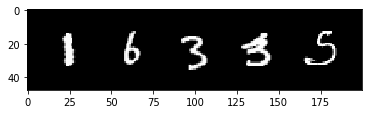

Prediction:  [1, 6, 3, 3, 5]


In [16]:
# Visualize some of the test images and see their prediction
test_iterator = iter(testloader)
X_test, y_test = test_iterator.next()
X_test, y_test = X_test[:5], y_test[:5]
visualize_data(X_test)

model.eval()
with torch.no_grad():
    # logits = model(X_test.cuda())
    logits = model(X_test)
    prediction = pred(logits)

print('Prediction: ', prediction.tolist())